# 实战案例4-1：根据可穿戴设备识别用户行为

* 项目：根据可穿戴设备识别用户行为
* 作者：[梁斌](https://drbinliang.github.io/)
* 日期：2017/10
* 提问：[小象问答](http://wenda.chinahadoop.cn/)
* 声明：[小象学院](http://www.chinahadoop.cn/)拥有完全知识产权的权利；只限于善意学习者在本课程使用，不得在课程范围外向任何第三方散播。任何其他人或机构不得盗版、复制、仿造其中的创意，我们将保留一切通过法律手段追究违反者的权利

## 1. 项目描述：
用户行为识别数据集是通过采集30天用户的行为创建的。数据是由绑定在用户腰间的智能手机记录的，该智能手机内嵌有传感器。创建该数据集的目的是用于识别/分类6组不同的用户行为。

数据集中的用户是由19-48岁间的30个志愿者组成的。戴有智能手机（Samsung Galaxy S II）的每个志愿者会做出6个行为（WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING）。通过智能手机的加速计和陀螺仪能够以50Hz的频率采集3个方向的加速度和3个方向的角速度。采集后的数据集随机分为两部分，70%用于模型的训练，30%用于模型的验证。

传感器信号已经预处理去除了噪声，并且在固定时间窗口（2.56s）内进行采样，每两个窗口间有50%的重叠部分（每个窗口有128个数据）。每个时间窗口同时提供时间和频率上的统计数据作为特征。

## 2. 数据集描述:
* Kaggle[提供的数据集](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones)。数据集包含训练集（**train.csv**）和测试集（**test.csv**），形式均为CSV文件。

每条记录提供有以下数据

* 3个方向的加速度，估计的身体加速度，3个方向的角速度。最终是561维的向量。
* 对应的标签
* 志愿者编号

## 3. 项目任务：
* 3.1 数据查看
* 3.2 数据建模及验证
* 3.3 模型及结果比较

## 4. 项目实现：

In [35]:
# 引入必要的包
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib notebook

In [5]:
# 解决matplotlib显示中文问题
# 仅适用于Windows
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# MacOS请参考 http://wenda.chinahadoop.cn/question/5304 修改字体配置

In [7]:
# 指定数据集路径
dataset_path = '../data'
train_datafile = os.path.join(dataset_path, 'train.csv')
test_datafile = os.path.join(dataset_path, 'test.csv')

# 加载数据
train_data = pd.read_csv(train_datafile)
test_data = pd.read_csv(test_datafile)

## 4.1 数据查看

In [9]:
print('训练集有{}条记录。'.format(len(train_data)))
print('测试集有{}条记录。'.format(len(test_data)))

训练集有7352条记录。
测试集有2947条记录。


<IPython.core.display.Javascript object>


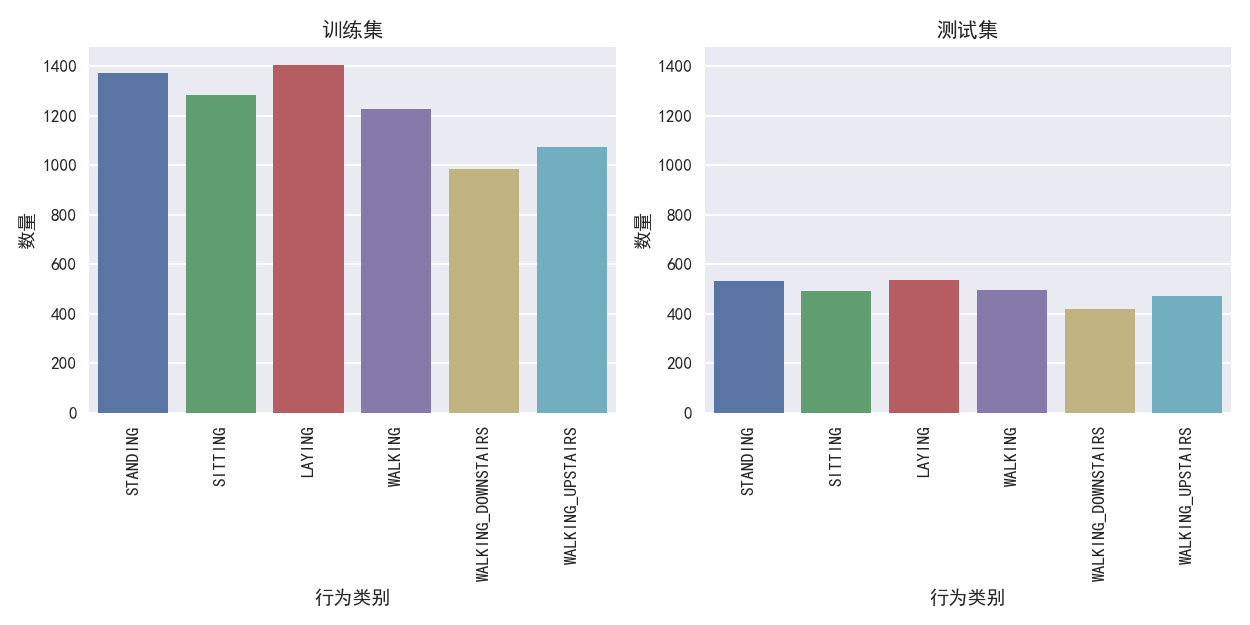

In [10]:
# 可视化各类别的数量统计图
plt.figure(figsize=(10, 5))

# 训练集
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x='Activity', data=train_data)

plt.title('训练集')
plt.xticks(rotation='vertical')
plt.xlabel('行为类别')
plt.ylabel('数量')

# 测试集
plt.subplot(1, 2, 2, sharey=ax1)
sns.countplot(x='Activity', data=test_data)

plt.title('测试集')
plt.xticks(rotation='vertical')
plt.xlabel('行为类别')
plt.ylabel('数量')

plt.tight_layout()

In [26]:
# 构建训练测试数据
# 特征处理
feat_names = train_data.columns[:-2].tolist()
X_train = train_data[feat_names].values
print('共有{}维特征。'.format(X_train.shape[1]))
X_test = test_data[feat_names].values

# 标签处理
train_labels = train_data['Activity'].values
test_labels = test_data['Activity'].values

# 使用sklearn.preprocessing.LabelEncoder进行类别标签处理
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y_train = label_enc.fit_transform(train_labels)
y_test = label_enc.transform(test_labels)

print('类别标签：', label_enc.classes_)
for i in range(len(label_enc.classes_)):
    print('编码 {} 对应标签 {}。'.format(i, label_enc.inverse_transform(i)))

共有561维特征。
类别标签： ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
编码 0 对应标签 LAYING。
编码 1 对应标签 SITTING。
编码 2 对应标签 STANDING。
编码 3 对应标签 WALKING。
编码 4 对应标签 WALKING_DOWNSTAIRS。
编码 5 对应标签 WALKING_UPSTAIRS。


## 4.2 数据建模及验证

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### 4.2.1 kNN

In [53]:
k_range = [5, 10, 15]

knn_models = []
knn_scores = []
knn_durations = []

for k in k_range:
    print('训练kNN（k={}）...'.format(k), end='')
    knn = KNeighborsClassifier(n_neighbors=k)
    # 训练模型
    start = time.time()
    knn.fit(X_train, y_train)
    
    # 计时
    end = time.time()
    duration = end - start
    print('耗时{:.4f}s'.format(duration), end=', ')
    
    # 验证模型
    score = knn.score(X_test, y_test)
    print('准确率：{:.3f}'.format(score))
    
    knn_models.append(knn)
    knn_durations.append(duration)
    knn_scores.append(score)

print()
knn_mean_duration = np.mean(knn_durations)
print('训练kNN平均耗时{:.4f}s'.format(knn_mean_duration))

# 记录最优模型
best_idx = np.argmax(knn_scores)
best_knn_acc = knn_scores[best_idx]
print('最优的kNN模型，k={}，准确率：{:.3f}'.format(knn_models[best_idx].get_params()['n_neighbors'], 
                                        best_knn_acc))

训练kNN（k=5）...耗时0.3439s, 准确率：0.900
训练kNN（k=10）...耗时0.3150s, 准确率：0.907
训练kNN（k=15）...耗时0.3215s, 准确率：0.905

训练kNN平均耗时0.3268s
最优的kNN模型，k=10，准确率：0.907


### 4.2.2 逻辑回归

In [71]:
c_range = [0.01, 1, 100]

lr_models = []
lr_scores = []
lr_durations = []

for c in c_range:
    print('训练Logistic Regression（C={}）...'.format(c), end='')
    lr_model = LogisticRegression(C=c)
    # 训练模型
    start = time.time()
    lr_model.fit(X_train, y_train)
    
    # 计时
    end = time.time()
    duration = end - start
    print('耗时{:.4f}s'.format(duration), end=', ')
    
    # 验证模型
    score = lr_model.score(X_test, y_test)
    print('准确率：{:.3f}'.format(score))
    
    lr_models.append(lr_model)
    lr_durations.append(duration)
    lr_scores.append(score)

print()
lr_mean_duration = np.mean(lr_durations)
print('训练Logistic Regression平均耗时{:.4f}s'.format(lr_mean_duration))

# 记录最优模型
best_idx = np.argmax(lr_scores)
best_lr_acc = lr_scores[best_idx]
print('最优的Logistic Regression模型，C={}，准确率：{:.3f}'.format(lr_models[best_idx].get_params()['C'], 
                                        best_lr_acc))

训练Logistic Regression（C=0.01）...耗时4.2926s, 准确率：0.938
训练Logistic Regression（C=1）...耗时6.7090s, 准确率：0.962
训练Logistic Regression（C=100）...耗时11.3761s, 准确率：0.962

训练Logistic Regression平均耗时7.4592s
最优的Logistic Regression模型，C=1，准确率：0.962


### 4.2.3 SVM

In [76]:
c_range = [100, 1000, 10000]

svm_models = []
svm_scores = []
svm_durations = []

for c in c_range:
    print('训练SVM（C={}）...'.format(c), end='')
    svm_model = SVC(C=c)
    # 训练模型
    start = time.time()
    svm_model.fit(X_train, y_train)
    
    # 计时
    end = time.time()
    duration = end - start
    print('耗时{:.4f}s'.format(duration), end=', ')
    
    # 验证模型
    score = svm_model.score(X_test, y_test)
    print('准确率：{:.3f}'.format(score))
    
    svm_models.append(svm_model)
    svm_durations.append(duration)
    svm_scores.append(score)

print()
svm_mean_duration = np.mean(svm_durations)
print('训练SVM平均耗时{:.4f}s'.format(svm_mean_duration))

# 记录最优模型
best_idx = np.argmax(svm_scores)
best_svm_acc = svm_scores[best_idx]
print('最优的SVM模型，C={}，准确率：{:.3f}'.format(svm_models[best_idx].get_params()['C'], 
                                        best_svm_acc))

训练SVM（C=100）...耗时3.5702s, 准确率：0.965
训练SVM（C=1000）...耗时3.2675s, 准确率：0.966
训练SVM（C=10000）...耗时3.2845s, 准确率：0.969

训练SVM平均耗时3.3741s
最优的SVM模型，C=10000，准确率：0.969


### 4.2.3 决策树

In [81]:
depth_range = [50, 100, 150]

tree_models = []
tree_scores = []
tree_durations = []

for depth in depth_range:
    print('训练决策树（max_depth={}）...'.format(depth), end='')
    tree_model = DecisionTreeClassifier(max_depth=depth)
    # 训练模型
    start = time.time()
    tree_model.fit(X_train, y_train)
    
    # 计时
    end = time.time()
    duration = end - start
    print('耗时{:.4f}s'.format(duration), end=', ')
    
    # 验证模型
    score = tree_model.score(X_test, y_test)
    print('准确率：{:.3f}'.format(score))
    
    tree_models.append(tree_model)
    tree_durations.append(duration)
    tree_scores.append(score)

print()
tree_mean_duration = np.mean(tree_durations)
print('训练决策树平均耗时{:.4f}s'.format(tree_mean_duration))

# 记录最优模型
best_idx = np.argmax(svm_scores)
best_tree_acc = tree_scores[best_idx]
print('最优的决策树模型，max_depth={}，准确率：{:.3f}'.format(tree_models[best_idx].get_params()['max_depth'], 
                                        best_tree_acc))

训练决策树（max_depth=50）...耗时5.1455s, 准确率：0.859
训练决策树（max_depth=100）...耗时5.2282s, 准确率：0.866
训练决策树（max_depth=150）...耗时5.3352s, 准确率：0.857

训练决策树平均耗时5.2363s
最优的决策树模型，max_depth=150，准确率：0.857


## 4.3 模型及结果比较

In [89]:
results_df = pd.DataFrame(columns=['Accuracy (%)', 'Time (s)'], index=['kNN', 'LR', 'SVM', 'DT'])
results_df['Accuracy (%)'] = [best_knn_acc * 100, best_lr_acc * 100, best_svm_acc * 100, best_tree_acc * 100]
results_df['Time (s)'] = [knn_mean_duration, lr_mean_duration, svm_mean_duration, tree_mean_duration]

results_df

Accuracy (%)  Time (s)
kNN     90.668476  0.326800
LR      96.199525  7.459200
SVM     96.878181  3.374051
DT      85.680353  5.236320

<IPython.core.display.Javascript object>


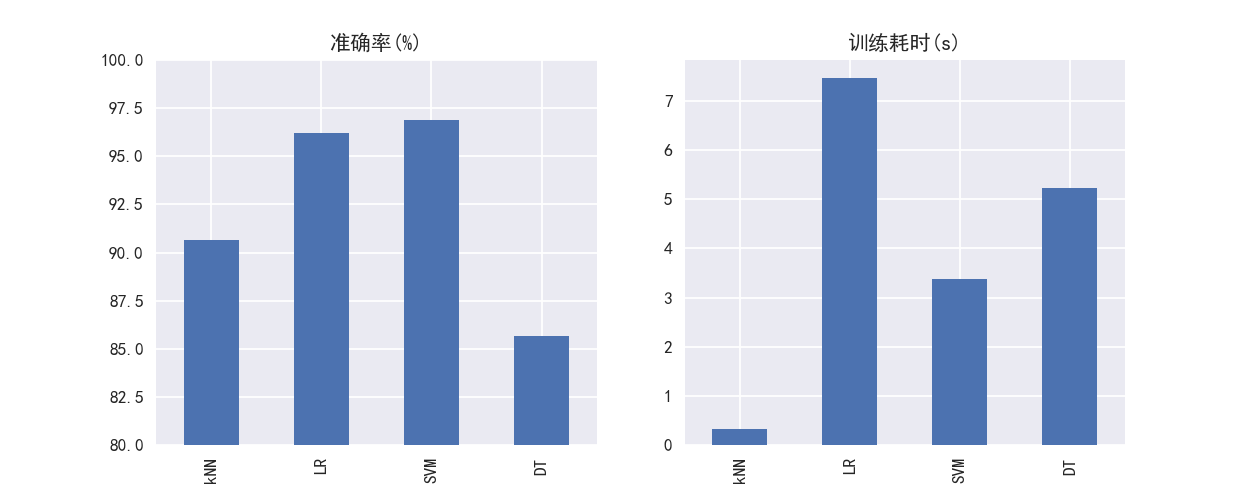

In [101]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
results_df.plot(y=['Accuracy (%)'], kind='bar', ylim=[80, 100], ax=ax1, title='准确率(%)', legend=False)

ax2 = plt.subplot(1, 2, 2)
results_df.plot(y=['Time (s)'], kind='bar', ax=ax2, title='训练耗时(s)', legend=False)

根据实验结果，SVM在该数据集上表现较好：准确率最高（96.88%），训练模型耗时较短（3.3741s）

## 5. 项目总结
* 该项目通过分析“人体行为识别”数据集，并在该数据集上进行建模操作，包括:
    * 数据可视化
    * 数据集特征、标签的处理
    * kNN, 逻辑回归，SVM，决策树模型的建立和训练
    * kNN, 逻辑回归，SVM，决策树模型的参数选择及结果影响
    * kNN, 逻辑回归，SVM，决策树模型的验证
* 课后学员可模仿该项目的流程与操作，在现有数据集上通过改变模型的参数，观察对模型的性能有何影响
* 该项目有配套的Python代码

## 6. 参考文献
* Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21st European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

* Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. Human Activity Recognition on Smartphones using a Multiclass Hardware-Friendly Support Vector Machine. International Workshop of Ambient Assisted Living (IWAAL 2012). Vitoria-Gasteiz, Spain. Dec 2012

* Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra, Jorge L. Reyes-Ortiz. Energy Efficient Smartphone-Based Activity Recognition using Fixed-Point Arithmetic. Journal of Universal Computer Science. Special Issue in Ambient Assisted Living: Home Care. Volume 19, Issue 9. May 2013

* Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. Human Activity Recognition on Smartphones using a Multiclass Hardware-Friendly Support Vector Machine. 4th International Workshop of Ambient Assited Living, IWAAL 2012, Vitoria-Gasteiz, Spain, December 3-5, 2012. Proceedings. Lecture Notes in Computer Science 2012, pp 216-223.

* Jorge Luis Reyes-Ortiz, Alessandro Ghio, Xavier Parra-Llanas, Davide Anguita, Joan Cabestany, Andreu Català. Human Activity and Motion Disorder Recognition: Towards Smarter Interactive Cognitive Environments. 21st European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.